# Curve Continuation

<ul id="top">
<li><a href="#Imports"> 
             Imports</a></li>
<li><a href="#Description-of-the-approach"> 
             Description of the approach</a></li>
</ul>

## Imports

In [7]:
using LinearAlgebra
using Plots 
using OrdinaryDiffEq
using Optim

using NLsolve
using BenchmarkTools

include("src/IRK8.jl")
include("src/3body.jl");

# Increasing the precision of our choreographies
We are going to use the Newton-Raphson method to increase the precision of our choreographies, and to generate new choreographies based on the ones we found via the local search. To represent the choreographies, we will use vector $z$:

$$
z_1 = x2(0), z_2 = y_2(0), z_3 = \dot x_2(0), z_4 = \dot y_2(0), z_5 = \dot x_3(0), z_6 = \dot y_3 (0), z_7 = T, z_8 = \beta, z_9 = P
$$

A more detailed explanation can be found in section 3.5 of the following document:
https://addi.ehu.es/handle/10810/53290

So far we have represented the solutions to the diferential equations using the vector $u = (x_{12},y_{12},x_{23},y_{23},x_{31},y_{31},\dot x_{1}, \dot y_{1},\dot x_{2}, \dot y_{2},\dot x_{3}, \dot y_{3}, t)$. Therefore, we need a function to "convert between $u$ and $z$". More precisely, we need a function $\chi$ such that $u(0) = \chi(z)$:
$$
\chi(z) = (3z_1,z_2,0,-2z_2,-3z_1,z_2,-z_3-z_5,-z_4-z_6,z_3,z_4,z_5,z_6, 0)
$$

In [8]:
chi(z) = [3*z[1], z[2], 0, -2*z[2], -3*z[1], z[2], 
          -z[3]-z[5], -z[4]-z[6], z[3], z[4], z[5], z[6], 0]

function chi!(u0, z) 
    u0[1] = 3*z[1]
    u0[2] = z[2]
    u0[3] = 0
    u0[4] = -2*z[2]
    u0[5] = -3*z[1]
    u0[6] = z[2]
    u0[7] = -z[3]-z[5]
    u0[8] = -z[4]-z[6]
    u0[9] = z[3]
    u0[10] = z[4]
    u0[11] = z[5]
    u0[12] = z[6]
    u0[13] = 0
    return nothing
end

chi! (generic function with 1 method)

Let $u$ be a solution to the differential equations concerning Newtonian gravitation. Then, $u$ is a choreography with relative angle $\beta$, physical period $P$, and total energy $-1/2$, if and only if it is a root of the following function:
$$
\begin{equation*}
g(u^*, u,\beta, P) =
\left(
\begin{matrix}
x_{12}^* - \cos(\beta)\, x_{23} + \sin(\beta)\, y_{23},\\
y_{12}^* - \sin(\beta)\, x_{23} - \cos(\beta)\, y_{23}, \\
x_{23}^* - \cos(\beta)\, x_{31} + \sin(\beta)\, y_{31},\\
y_{23}^* - \sin(\beta)\, x_{31} - \cos(\beta)\, y_{31}, \\
\dot x_1^* -  \cos(\beta)\, \dot x_2 + \sin(\beta)\, \dot y_2\\
\dot y_1^* -  \sin(\beta)\, \dot x_2 - \cos(\beta)\, \dot y_2 \\
H(u) + \frac12 \\
u_{13}^* - P
\end{matrix}
\right)
\end{equation*}
$$
Again, more details can be found in the document referenced in the previous block.

In [9]:
function g(uT, u0, beta, P)
    (sinb, cosb) = sincos(beta)
    return [uT[1] - cosb*u0[3] + sinb*u0[4],
            uT[2] - sinb*u0[3] - cosb*u0[4],
            uT[3] - cosb*u0[5] + sinb*u0[6],
            uT[4] - sinb*u0[5] - cosb*u0[6],
            uT[7] - cosb*u0[9] + sinb*u0[10],
            uT[8] - sinb*u0[9] - cosb*u0[10],
            ThreeBodyEnergy(u0) + 0.5,
            uT[13] - P]
end

g (generic function with 1 method)

When using Newton's method, we are going to be dealing with solutions encoded using the vector $z$, which really just represents the initial configuration $u(0)$. Since $g$ takes $u(T)$ as an argument, we are going to approximate it using a numerical method or order $n$: 
$$
u(T) \approx \phi_n(z)
$$

In [10]:
function phi(z::Vector{Float64}, odef, p, dt::Float64=0.1)
    u0 = chi(z)
    T = z[7]
    prob = ODEProblem(odef,u0,(0.,T),p)
    sol=solve(prob,Vern9(), saveat=T,
              adaptive=false,dt=dt)
    return sol.u[end]
end

phi (generic function with 2 methods)

We are also going to define a function that, given a vector $z$, it displays the curve traced by the bodies for us.

In [11]:
function draw_z(z, odef, p, n, m, iter, title="", triangles=false)
    u0 = chi(z)
    T = z[7] * iter
    return draw(u0, odef, p, 0., T, n, m, title, triangles)
end

draw_z (generic function with 3 methods)

Let's take the heart choreography that we obtained doing a local search. 

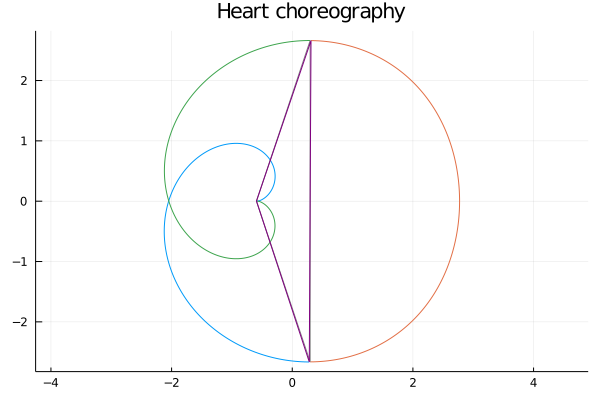

In [16]:
z = [0.296625, -2.663432, 0.632399, 0.001858, -0.632399, 0.001858, 8.703583, -0.005315, 8.682863]
p = nothing
odef = ThreeBodyODEGlobalTR!
draw_z(z, odef, p, 256, 2, 1, "Heart choreography", true)

Since it is a choreography, $g$ outputs a value close to 0:

In [17]:
u0 = chi(z)
uT = phi(z, odef, p, 0.01)
z[9] = uT[end]
res = g(uT, u0, z[8], z[9])
norm(res)

4.9501293782458294e-5

Function $f$ is defined in order to follow the curves traced by relative choreographies, by calculating the intersection between the curves and the hyperplane $\alpha \cdot (z-z^0) = 0$:
\begin{equation*}
f(z):=
\left(\begin{matrix}
g(\phi_n(z), \chi(z),z_8)\\
\alpha \cdot (z-z^0)
\end{matrix}\right)
\end{equation*}

In [18]:
struct F3Cor
    odef
    p
    alpha::Vector{Float64}
    z0::Vector{Float64}
    u0::Vector{Float64}
    dt::Float64
end

function F3Cor(odef, p, u, z0, dt::Float64=0.1)
    alpha = similar(z0)
    u0 = similar(u)
    return F3Cor(odef, p, alpha, z0, u0, dt)
end

function (f!::F3Cor)(F, z)
    odef = f!.odef
    p = f!.p
    alpha = f!.alpha
    z0 = f!.z0
    u0 = f!.u0
    dt = f!.dt
    T = z[7] 
    chi!(u0,z)
    beta = z[8]
    P = z[9]
    (sinb, cosb) = sincos(beta)
    F[1] = dot(alpha, z-z0)
    uT = phi(z, odef, p, dt)
    F[2] = uT[1] - cosb*u0[3] + sinb*u0[4]
    F[3] = uT[2] - sinb*u0[3] - cosb*u0[4]
    F[4] = uT[3] - cosb*u0[5] + sinb*u0[6]
    F[5] = uT[4] - sinb*u0[5] - cosb*u0[6]
    F[6] = uT[7] - cosb*u0[9] + sinb*u0[10]
    F[7] = uT[8] - sinb*u0[9] - cosb*u0[10]
    F[8] = ThreeBodyEnergy(u0) + 0.5
    F[9] = uT[13] - P
    return nothing # norm(F[2:end]) # Hau berez ez da beharrezkoa, return nothing izan zitekeen
end

If we draw the heart choreography for multiple iterations, it is clear that our approximation of the initial state is not very precise:

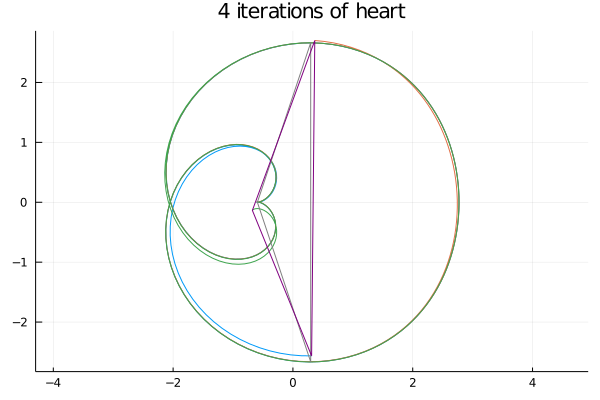

In [20]:
z = [0.296625, -2.663432, 0.632399, 0.001858, -0.632399, 0.001858, 8.703583, -0.005315, 8.682863]
draw_z(z, odef, p, 256, 2, 4, "4 iterations of heart", true)

The algorithm that we have so far is designed for continuing the curve of a given choreography. However, given an approximation of a choreography with relative angle $\beta$, if we set the hyperplane to the following:
$$
\alpha = (0, 0, 0, 0, 0, 0, 0, 1, 0)
$$

and we choose $z^0_8 = \beta$, then we are going to get a very precise approximation of the desired choreography:

In [23]:
u0 = chi(z)
dt = 0.1
z0 = similar(z)
f! = F3Cor(odef,nothing, u0, z0, dt ) # Datu egitura funtzionala sortu
f!.alpha .= 0
f!.z0 .= 0
f!.alpha[8] = 1
f!.z0[8] = 0 # beta=0

0

In [30]:
F = similar(z)
f!(F, z)
norm(F[1:8])

0.00531523051034426

In [31]:
@time res = nlsolve(f!,z,ftol=1e-12,method=:newton, iterations=10, show_trace=true)
(res.iterations, converged(res))

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.306944e+00              NaN
     1     6.326366e-05     2.835430e+01
     2     1.343705e-09     1.376767e-11
     3     2.864375e-14     6.881848e-18
  0.129751 seconds (1.53 M allocations: 146.836 MiB, 26.83% gc time)


(3, true)

In [32]:
z_new = res.zero;

In [33]:
f!(F, z_new)
norm(F)

3.869457752215254e-14

We can also visually check that the new $z$ is in fact more precise by displaying the curve for 10 iterations:

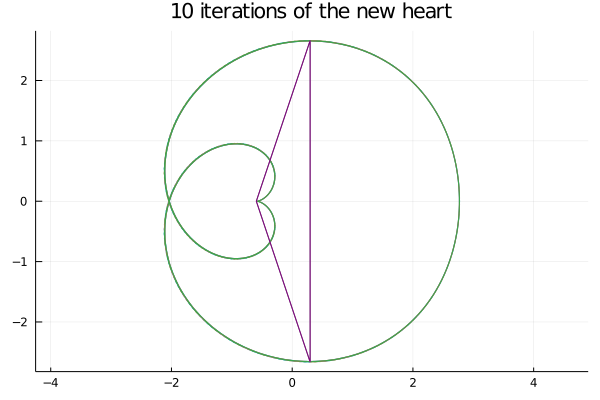

In [35]:
draw_z(z_new, odef, p, 256, 2, 10, "10 iterations of the new heart", true)

# Continuation

To continue the curves, we just need to slowly change $\alpha$. We are now going to use the ladybug choreography:

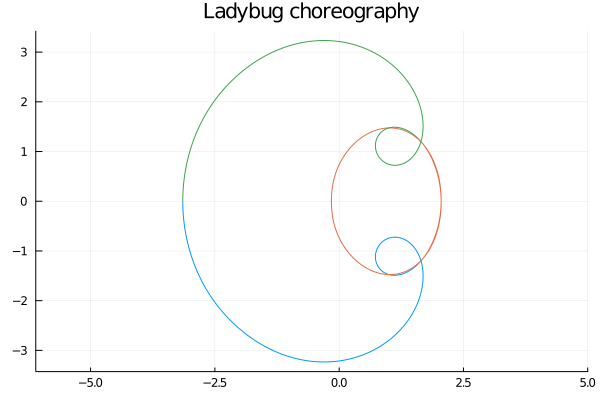

In [43]:
z = [1.5730952876277442, -1.2761780586722435, 0.28536136593273337, 0.2704704204756321, -0.2853613659315564, 0.27047042047924325, 13.669357435280828, 0.0, 19.792370239847777]
draw_z(z, odef, p, 256, 2, 1, "Ladybug choreography", false)

We first get $z_1$ and $z_2$:

In [51]:
dbeta = -0.01

z1 = z

f!.alpha .= 0
f!.alpha[8] = 1
f!.z0 .= z1
f!.z0[8] += dbeta

F = similar(z)
f!(F, z)

res = nlsolve(f!,z1,ftol=1e-8,method=:newton, iterations=10,show_trace=true)
z2 = res.zero
zz = [z1, z2];

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e-02              NaN
     1     1.588563e-04     1.645748e-03
     2     1.515756e-08     1.189200e-09
     3     3.286260e-14     6.844718e-14


Continuation

In [54]:
ukopmax = 300 # 300
iters0 = 2
iters1 = 4
maxiters = 6
lambda = abs(dbeta)
mu1 = 1.2
mu2 = 1.1
mu3 = 1.2
R = similar(z2)

i=0
cont = true

while cont
    i += 1 
    println(i)
    @. f!.alpha = zz[end] - zz[end-1]
    @. f!.alpha /= norm(f!.alpha)
    @. f!.z0 = zz[end] + f!.alpha * lambda
#    z00 = copy(f!.z0)
    z00 = zz[end]   
    res = nlsolve(f!,z00,ftol=1e-8,method=:newton, iterations=maxiters, show_trace=false)
    iters = res.iterations
    if converged(res)
        push!(zz, res.zero)
        println("T=", res.zero[7], ", beta=", res.zero[8],
                ", lambda=", lambda, ", it=", res.iterations, ", normres=", f!(R,res.zero))
        (iters <= iters0) ? lambda *=mu1 : nothing
        (iters >= iters1) ? lambda /=mu2  : nothing
    else
        lambda /= mu3
    end
    cont = (i < ukopmax) && sign(zz[end][8])==sign(zz[end-1][8])
end

1
T=12.311125388208017, beta=-0.5868526595869201, lambda=0.01, it=4, normres=nothing
2
T=12.30982503556556, beta=-0.5701492720117844, lambda=0.00909090909090909, it=3, normres=nothing
3
T=12.314754565539115, beta=-0.5524629971424349, lambda=0.00909090909090909, it=3, normres=nothing
4
T=12.321988879556816, beta=-0.5371670912825856, lambda=0.00909090909090909, it=3, normres=nothing
5
T=12.33094848016977, beta=-0.5221569923929088, lambda=0.00909090909090909, it=3, normres=nothing
6
T=12.341184406746239, beta=-0.5073507753586546, lambda=0.00909090909090909, it=3, normres=nothing
7
T=12.35242863798269, beta=-0.4927000257573716, lambda=0.00909090909090909, it=3, normres=nothing
8
T=12.364504583154629, beta=-0.4781731857315226, lambda=0.00909090909090909, it=3, normres=nothing
9
T=12.377287739250828, beta=-0.4637482555499611, lambda=0.00909090909090909, it=3, normres=nothing
10
T=12.390685873108673, beta=-0.44940912812294553, lambda=0.00909090909090909, it=3, normres=nothing
11
T=12.40462802

Visualize the curve that we just followed:

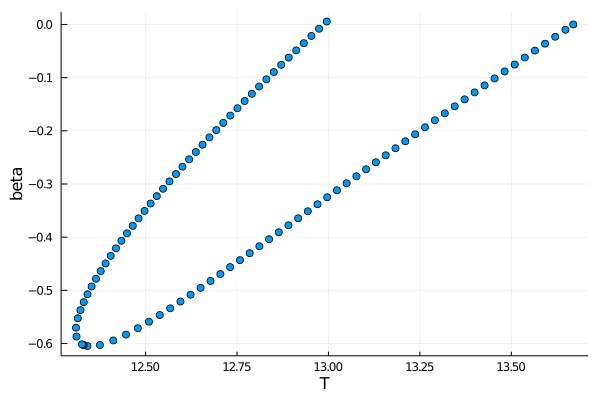

In [58]:
TT = [z[7] for z in zz]
bb =  [z[8] for z in zz]
scatter(TT,bb, legend=false, xlabel="T", ylabel="beta")

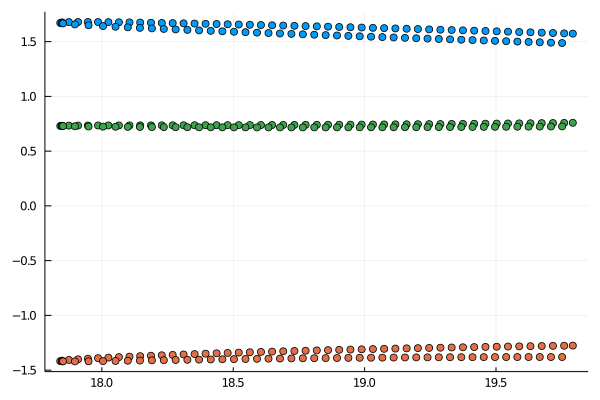

In [59]:
PP = [z[9] for z in zz]
xx2 = [z[1] for z in zz]
yy2 = [z[2] for z in zz]
gg2 = [atan(z[4],z[3]) for z in zz]
scatter(PP,xx2, legend=false)
scatter!(PP,yy2)
scatter!(PP,gg2)

The choreography on which the algorithm halted is also an absolute choreography. Interestingly, it also has the same geometry:

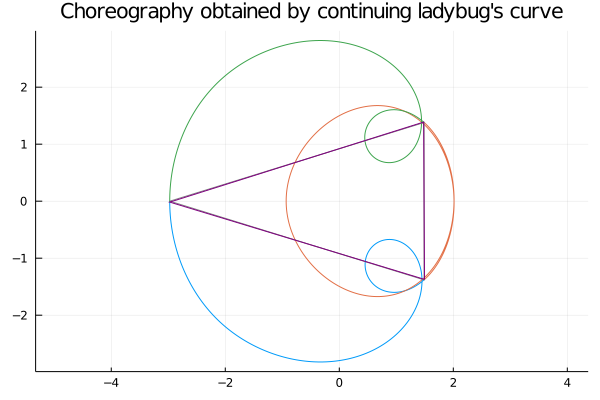

In [60]:
draw_z(zz[end], odef, p, 256, 2, 1, "Choreography obtained by continuing ladybug's curve", true)

We can again plot the choreography that we started with to see the difference:

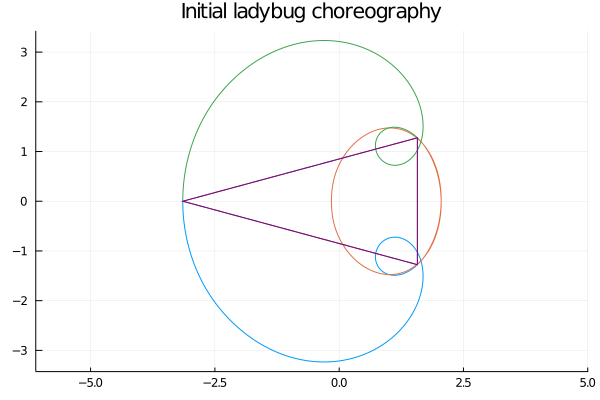

In [61]:
draw_z(zz[1], odef, p, 256, 2, 1, "Initial ladybug choreography", true)

# Automatize continuation

The following code was written in order to automatically continue the curves of all 1500+ choreographies that we found.

In [65]:
function farey_sequence(n::Int64)
    (a, b, c, d) = (0, 1, 1, n)
    frakzioak = [a//b]
    while c <= n
        k = div((n + b),d) 
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        push!(frakzioak, a//b)
    end
    return frakzioak
end

farey_sequence (generic function with 1 method)

In [66]:
D = 16
frakzioak = farey_sequence(D)[1:end-1] # azkenengo frakzioa, 1/1, ez dugu behar
angeluak = 2pi*frakzioak .- pi
# -pi angeluaz mugitu dugunez dena, frakzioak aldatuko ditugu lehentasunak lortzeko
frakzioak = frakzioak .- 1//2
lehentasunak = denominator.(frakzioak) .+ numerator.(frakzioak)/D
angeluak, lehentasunak

([-3.141592653589793, -2.748893571891069, -2.722713633111154, -2.6927937030769655, -2.658270706883671, -2.6179938779914944, -2.5703939893007397, -2.5132741228718345, -2.443460952792061, -2.356194490192345  …  2.3038346126325155, 2.356194490192345, 2.443460952792061, 2.5132741228718345, 2.5703939893007393, 2.617993877991494, 2.6582707068836715, 2.6927937030769655, 2.7227136331111543, 2.7488935718910685], [1.9375, 15.5625, 29.1875, 6.8125, 25.3125, 11.6875, 21.4375, 4.875, 17.5625, 7.8125  …  30.6875, 8.1875, 18.4375, 5.125, 22.5625, 12.3125, 26.6875, 7.1875, 30.8125, 16.4375])

In [67]:
# Figure-eight
z = [1.3914224855041892, -0.8888058233705901, 0.683796458425381, -0.14559734865585836, -0.6837964584253811, -0.14559734865585874, 5.372134247663828, 0.0, 8.709369406436208]

dbeta = -0.01

# z1 eta z2 lortu
z1 = z

f!.alpha .= 0
f!.alpha[8] = 1
f!.z0 .= z1
f!.z0[8] += dbeta

F = similar(z)
(f!(F, z),  norm(F))
print(F)

res = nlsolve(f!,z1,ftol=1e-8,method=:newton, iterations=10,show_trace=true)

z2 = res.zero
zz = [z1, z2]
# bilaketa egin
ukopmax = 300
iters0 = 2
iters1 = 4
maxiters = 6
lambda = abs(dbeta)
mu1 = 1.2
mu2 = 1.1
mu3 = 1.2
R = similar(z2)

i=0
cont = true

# beste kurben kandidatuen zerrenda
kandidatuak_denak = []

# angeluen zerrendan koreografiak duen beta non kokatzen den
# angeluak[bind] <= beta < angeluak[bind+1]
beta = ((z1[8] + pi) % 2pi) - pi

bind = length(angeluak)
for i in 2:length(angeluak)
    if beta < angeluak[i]
        bind = i-1
        break
    end
end

println(bind)
println(beta)
println(angeluak[bind])
        
# kurba honen ordezkarien kandidatuak
kand_orain = [fill(Inf, 9) for _ in 1:length(angeluak)]

berria_da = true

while cont
    i += 1 
    println(i)
    @. f!.alpha = zz[end] - zz[end-1]
    @. f!.alpha /= norm(f!.alpha)
    @. f!.z0 = zz[end] + f!.alpha * lambda
#    z00 = copy(f!.z0)
    z00 = zz[end]   
    res = nlsolve(f!,z00,ftol=1e-8,method=:newton, iterations=maxiters, show_trace=true)
    iters = res.iterations
    if converged(res)
        push!(zz, res.zero)
        println("T=", res.zero[7], ", beta=", res.zero[8],
                ", lambda=", lambda, ", it=", res.iterations, ", normres=", f!(R,res.zero))
        (iters <= iters0) ? lambda *=mu1 : nothing
        (iters >= iters1) ? lambda /=mu2  : nothing
        
        beta = ((res.zero[8] + pi) % 2pi) - pi
        
        """
        angelu_berria = false
        # begiratu ea angelua tartez aldatu den
        if beta < angeluak[bind]
            ind_berria = bind
            bind = bind-1 <= 0 ? length(angeluak) : bind-1
            angelu_berria = true
        elseif beta >= angeluak[(bind)%(length(angeluak))+1]
            bind = (bind)%(length(angeluak))+1
            angelu_berria = true
            ind_berria = bind
        end
        """
        
        angelu_berria = false
        if f!.alpha[8] < 0
            if bind == 1
                cond = beta > angeluak[end]
            else
                cond = beta < angeluak[bind]
            end
            if cond
                ind_berria = bind
                bind = bind-1 <= 0 ? length(angeluak) : bind-1
                angelu_berria = true
            end
        else
            if bind == length(angeluak)
                cond = beta < angeluak[2]
            else
                cond = beta > angeluak[bind+1]
            end
            if cond
                bind = (bind)%(length(angeluak))+1
                angelu_berria = true
                ind_berria = bind
            end
        end
        
        println("bind: ", bind)
        
        # aldatu bada, tartean piren zatitzailea daukagu. Kandidatu bat da
        if angelu_berria
            # lortu angeluari dagokion z
            f!.alpha .= 0
            f!.alpha[8] = 1
            f!.z0 .= res.zero
            # res.zero[8] > pi edo < -pi bada, angeluak listako balioengandik desberdina da
            # solve egiteko antzekoak izatea nahi dugu
            f!.z0[8] = angeluak[ind_berria] + 2pi*floor((res.zero[8]+pi)/(2pi))
            
            println("indb: ", ind_berria)
            println("beta: ", beta)
            println("bcmp: ", f!.z0[8])
            
            res = nlsolve(f!,res.zero,ftol=1e-8,method=:newton, iterations=10,show_trace=true)
            z_kand = res.zero
            
            # konparatu angelu horrekin aurkitutako besteekin. Existitzen bada, amaitu
            for bestea in kandidatuak_denak
                diff = bestea[ind_berria]-z_kand
                if dot(diff, diff) < 0.5
                    println("Dagoeneko aurkitu dugu!")
                    berria_da = false
                    break
                end
            end
            
            # periodorik laburrena duena hartuko dugu
            # hasieran Inf-ekin hasi dugula kontutan izan
            if z_kand[7] < kand_orain[ind_berria][7]
                println("Kandidatua!")
                println(z_kand[8])
                println(angeluak[ind_berria])
                kand_orain[ind_berria] = z_kand
            end
        end
        
    else
        lambda /= mu3
    end
    cont = berria_da && (i < ukopmax) && sign(zz[end][8])==sign(zz[end-1][8])
end
                
if berria_da
    push!(kandidatuak_denak, kand_orain)
end

kandidatuak_denak

[0.01, 3.672559493633357e-15, 5.773159728050814e-15, -8.881784197001252e-16, 2.4424906541753444e-15, -2.1094237467877974e-15, -1.4155343563970746e-15, 2.220446049250313e-16, 1.7763568394002505e-15]Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e-02              NaN
     1     5.266863e-04     1.629299e-04
     2     4.609883e-08     2.132731e-09
     3     2.131628e-14     4.201281e-14
41
0.0
0.0
1
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     7.251872e-03     2.360439e-03
     2     7.203216e-06     5.469253e-07
     3     1.364931e-09     1.935585e-09
T=5.373044641994551, beta=-0.04782099284656661, lambda=0.01, it=3, normres=nothing
bind: 40
indb: 41
beta: -0.04782099284656649
bcmp: 0.0
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.782099e-02              NaN
     1     1.187007e-02     3.730517e-03
  

     1     2.513040e-03     1.864102e-03
     2     1.078587e-06     2.321076e-07
     3     7.722933e-12     1.172877e-11
T=5.501305010446833, beta=-0.5572298314006419, lambda=0.01, it=3, normres=nothing
bind: 33
17
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.477417e-03     1.846542e-03
     2     9.527989e-07     2.229693e-07
     3     5.882628e-12     8.992981e-12
T=5.516408337015167, beta=-0.5873526462311012, lambda=0.01, it=3, normres=nothing
bind: 33
18
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     2.438550e-03     1.830820e-03
     2     8.425482e-07     2.148476e-07
     3     4.518386e-12     6.984259e-12
T=5.532224372594134, beta=-0.616993620716587, lambda=0.01, it=3, normres=nothing
bind: 33
19
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02     

     2     4.829557e-10     4.030501e-10
Kandidatua!
-1.0471975511965979
-1.0471975511965979
36
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.545751e-03     1.804918e-03
     2     1.406596e-07     1.767244e-07
     3     2.775558e-13     7.086962e-13
T=5.932001235248923, beta=-1.072682698882242, lambda=0.01, it=3, normres=nothing
bind: 27
37
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.495463e-03     1.817169e-03
     2     1.328812e-07     1.786378e-07
     3     2.606804e-13     6.835830e-13
T=5.960569880247769, beta=-1.0938595958312534, lambda=0.01, it=3, normres=nothing
bind: 27
38
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.445658e-03     1.831008e-03
     2     1.261463e-07     1.808553e-07
     3     2.398082e-13   

     1     1.071908e-03     2.412372e-03
     2     1.200210e-07     2.492292e-07
     3     1.953993e-14     1.517142e-13
T=6.645845820725055, beta=-1.4181698905548819, lambda=0.01, it=3, normres=nothing
bind: 23
57
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     1.132478e-03     2.466382e-03
     2     1.209226e-07     2.526913e-07
     3     8.881784e-15     1.163572e-13
T=6.6900904317167695, beta=-1.431287700916706, lambda=0.01, it=3, normres=nothing
bind: 22
indb: 23
beta: -1.431287700916706
bcmp: -1.4279966607226333
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.291040e-03              NaN
     1     7.622351e-05     1.634349e-04
     2     1.341717e-09     4.959801e-09
Kandidatua!
-1.4279966607226333
-1.4279966607226333
58
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1   

     3     1.028511e-12     1.984028e-12
T=7.826653302675165, beta=-1.6285750237061378, lambda=0.01, it=3, normres=nothing
bind: 20
79
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.037559e-03     4.198162e-03
     2     7.747327e-07     2.143218e-07
     3     1.142197e-12     2.290733e-12
T=7.890440022062676, beta=-1.6347687143571736, lambda=0.01, it=3, normres=nothing
bind: 20
80
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.135023e-03     4.292076e-03
     2     8.249797e-07     2.076008e-07
     3     1.284306e-12     2.621435e-12
T=7.955041909743097, beta=-1.6407243602027652, lambda=0.01, it=3, normres=nothing
bind: 20
81
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     3.232052e-03     4.386154e-03
     2     8.760564e-07    

     2     1.989114e-06     6.651492e-08
     3     8.082424e-12     1.447361e-11
T=9.551365414010276, beta=-1.7250492510822972, lambda=0.01, it=3, normres=nothing
bind: 19
103
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     5.045354e-03     6.240035e-03
     2     2.037952e-06     6.221149e-08
     3     8.311574e-12     1.512173e-11
T=9.630369754338602, beta=-1.7273035296121115, lambda=0.01, it=3, normres=nothing
bind: 19
104
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     5.105221e-03     6.303241e-03
     2     2.086741e-06     5.429214e-08
     3     7.872814e-12     1.850083e-11
T=9.709772632796712, beta=-1.7294596030006781, lambda=0.01, it=3, normres=nothing
bind: 19
105
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     5.163644e-03 

     0     9.000000e-02              NaN
     1     6.059993e-03     7.322636e-03
     2     2.888350e-06     1.150279e-08
     3     2.255263e-11     3.366601e-11
T=11.537200576891586, beta=-1.759006738666362, lambda=0.01, it=3, normres=nothing
bind: 18
127
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.089034e-03     7.353652e-03
     2     2.915273e-06     1.066537e-08
     3     2.307665e-11     3.424461e-11
T=11.623016169151837, beta=-1.7597777540045523, lambda=0.01, it=3, normres=nothing
bind: 18
128
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.117048e-03     7.383553e-03
     2     2.941400e-06     9.886805e-09
     3     2.375344e-11     3.481059e-11
T=11.709004720468597, beta=-1.7605149290010107, lambda=0.01, it=3, normres=nothing
bind: 18
129
Iter     f(x) inf-norm    Step 2-norm 
------   -------------

     3     6.007372e-11     4.399297e-11
T=13.633099797550505, beta=-1.770587558663669, lambda=0.01, it=3, normres=nothing
bind: 18
151
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.538650e-03     7.829855e-03
     2     3.354952e-06     1.694229e-09
     3     7.005063e-11     4.427604e-11
T=13.72161585692658, beta=-1.7708498162858608, lambda=0.01, it=3, normres=nothing
bind: 18
152
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.549644e-03     7.841356e-03
     2     3.366395e-06     1.570736e-09
     3     8.129941e-11     4.454343e-11
T=13.810195762507929, beta=-1.7711005427194615, lambda=0.01, it=3, normres=nothing
bind: 18
153
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.560193e-03     7.852383e-03
     2     3.377470e-06

     0     9.000000e-02              NaN
     1     6.708704e-03     8.006240e-03
     2     3.555294e-06     3.029823e-10
     3     1.845814e-09     4.847123e-11
T=15.860151025398693, beta=-1.7746137257058159, lambda=0.01, it=3, normres=nothing
bind: 18
176
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.712721e-03     8.010334e-03
     2     3.562242e-06     2.825384e-10
     3     2.129643e-09     4.851746e-11
T=15.94966152549201, beta=-1.7746989157014519, lambda=0.01, it=3, normres=nothing
bind: 18
177
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.000000e-02              NaN
     1     6.716574e-03     8.014253e-03
     2     3.569756e-06     2.634146e-10
     3     2.451523e-09     4.863283e-11
T=16.039193403942964, beta=-1.774780358146378, lambda=0.01, it=3, normres=nothing
bind: 18
178
Iter     f(x) inf-norm    Step 2-norm 
------   --------------

     1     2.579711e-03     3.109008e-03
     2     6.876743e-07     2.873035e-12
     3     9.264311e-09     8.685634e-13
T=17.70930518475169, beta=-1.7757844094996968, lambda=0.006209213230591549, it=3, normres=nothing
bind: 18
199
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.588292e-02              NaN
     1     2.580221e-03     3.109411e-03
     2     7.074487e-07     3.440865e-12
     3     1.082098e-08     8.494528e-13
     4     3.814939e-10     2.804001e-17
T=17.765066356438187, beta=-1.7758055042873462, lambda=0.006209213230591549, it=4, normres=nothing
bind: 18
200
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.080265e-02              NaN
     1     2.129351e-03     2.570087e-03
     2     5.358787e-07     4.069762e-12
     3     9.762984e-09     3.534252e-13
T=17.815761244657658, beta=-1.7758241765526606, lambda=0.005644739300537772, it=3, normres=nothing
bind: 18
201
Iter     f(x)

     0     1.216175e-02              NaN
     1     1.214220e-04     1.474568e-04
     2     1.425012e-07     2.424727e-12
     3     9.554179e-09     1.153411e-14
T=18.344769110241717, beta=-1.7759931333143326, lambda=0.001351305709310395, it=3, normres=nothing
bind: 18
221
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.216175e-02              NaN
     1     1.214367e-04     1.474600e-04
     2     1.468811e-07     2.482799e-12
     3     9.935951e-09     1.262691e-14
T=18.356911372934704, beta=-1.775996509059501, lambda=0.001351305709310395, it=3, normres=nothing
bind: 18
222
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.216175e-02              NaN
     1     1.214507e-04     1.474629e-04
     2     1.513319e-07     2.519447e-12
     3     1.046309e-08     1.093349e-14
     4     2.703927e-09     1.312138e-16
T=18.36905374791873, beta=-1.7759998643777255, lambda=0.001351305709310395, it=4, no

     2     1.054291e-07     8.735962e-13
     3     1.035165e-08     1.092706e-14
     4     1.644134e-09     2.164294e-16
T=18.52366640769271, beta=-1.7760408493359503, lambda=0.0006303940863128477, it=4, normres=nothing
bind: 18
243
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.157770e-03              NaN
     1     2.211771e-05     2.653035e-05
     2     9.718696e-08     7.226309e-13
     3     8.674957e-09     5.451107e-15
T=18.52881660780485, beta=-1.7760421606179206, lambda=0.0005730855330116796, it=3, normres=nothing
bind: 18
244
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     5.157770e-03              NaN
     1     2.212333e-05     2.653058e-05
     2     9.923906e-08     7.740388e-13
     3     1.007009e-08     1.142447e-14
     4     2.148029e-09     1.026226e-15
T=18.533966809354418, beta=-1.7760434687029998, lambda=0.0005730855330116796, it=4, normres=nothing
bind: 18
245
Iter     f(

     1     1.045969e-05     1.237862e-05
     2     8.648315e-08     4.477790e-13
     3     8.494754e-09     3.266421e-15
T=18.622368789992745, beta=-1.776065399702487, lambda=0.00039142513012204046, it=3, normres=nothing
bind: 18
266
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.522826e-03              NaN
     1     1.046084e-05     1.237871e-05
     2     8.684252e-08     4.459627e-13
     3     9.560840e-09     5.881972e-15
T=18.62588670016087, beta=-1.7760662523579778, lambda=0.00039142513012204046, it=3, normres=nothing
bind: 18
267
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     3.522826e-03              NaN
     1     1.046101e-05     1.237873e-05
     2     8.720406e-08     4.356662e-13
     3     9.279977e-09     4.650432e-15
T=18.629404613607466, beta=-1.7760671035859472, lambda=0.00039142513012204046, it=3, normres=nothing
bind: 18
268
Iter     f(x) inf-norm    Step 2-norm 
------   -

     0     2.646751e-03              NaN
     1     5.997709e-06     6.988246e-06
     2     7.892544e-08     3.138387e-13
     3     1.015823e-08     6.170755e-15
     4     1.344105e-09     1.467400e-16
T=18.691050039876906, beta=-1.776081779683874, lambda=0.00029408349370551494, it=4, normres=nothing
bind: 18
289
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.406138e-03              NaN
     1     4.982668e-06     5.775461e-06
     2     7.211471e-08     2.584834e-13
     3     9.327386e-09     5.461128e-15
T=18.69345294334132, beta=-1.7760823424096208, lambda=0.0002673486306413772, it=3, normres=nothing
bind: 18
290
Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.406138e-03              NaN
     1     4.982305e-06     5.775381e-06
     2     7.254778e-08     2.583867e-13
     3     8.582132e-09     3.371344e-15
T=18.695855817465716, beta=-1.776082904901144, lambda=0.0002673486306413772, it=3,

1-element Array{Any,1}:
 [[Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf]  …  [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf], [Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf, Inf]]

If we filter the list to only keep valid choreographies, we see that we obtained 23 choreographies out of the figure-eight that we started with:

In [68]:
kandidatuak = kandidatuak_denak[1]
koreografiak = [kor for kor in kandidatuak if kor[1] != Inf]
length(koreografiak)

23

It turns out that the celtic knot is one of them!

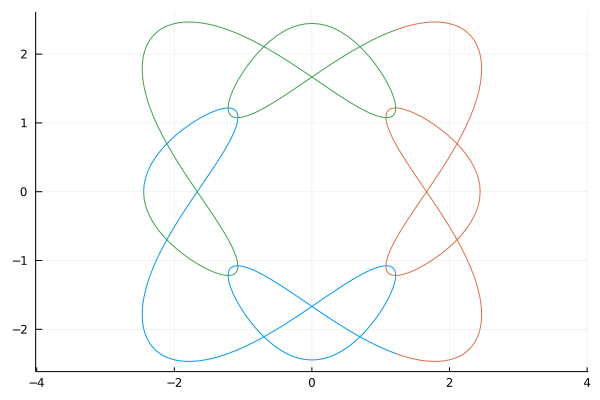

In [69]:
draw_z(koreografiak[3], odef, p, 256, 2, 4)

The are also many other interesting choreographies in this list:

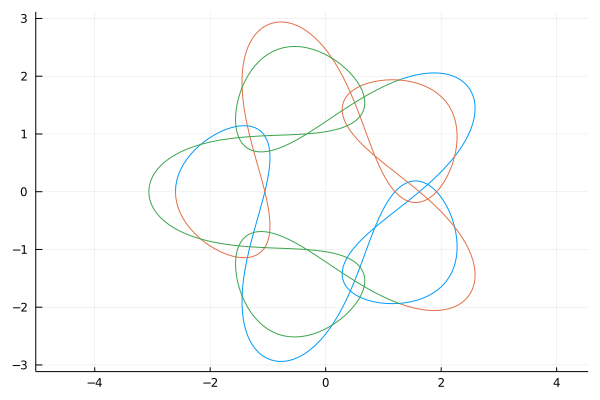

In [97]:
draw_z(koreografiak[7], odef, p, 256, 2, 5)